# Flat Unrolled Cascade - Test

- Single-channel data
- Images are 256x256
- R=5 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys

# Importing our model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet

# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

Using TensorFlow backend.


In [2]:
## PARAMETERS
H,W = 256,256 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

# Train Set 
test_path = "/home/ubuntu/volume1/Raw-data/SC/Test/*.npy"
kspace_files_test = np.asarray(glob.glob(test_path))

print(kspace_files_test[-1])
print(len(kspace_files_test))

/home/ubuntu/volume1/Raw-data/SC/Test/e14296s4_P09216.7.npy
10


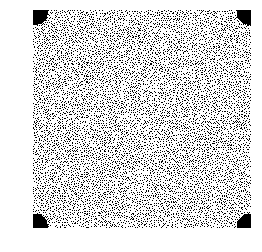

Undersampling: 0.800750732421875


In [3]:
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../Data/Sampling-patterns/256x256/poisson_center_radius=18_20perc.npy") \
                                    ,axes = (1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                                          axis = -1)[0]


# White pixels are retrospectively discarded
plt.figure()
plt.imshow(var_sampling_mask[:,:,0],cmap = "gray")
plt.axis("off")
plt.show()

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)

In [4]:
# Training our model
model_name = "../Models/flat_unrolled_cascade_ikikii.hdf5"
model = fsnet.deep_cascade_flat_unrolled("ikikii", H, W)
opt = Adam(lr = 1e-3,decay = 1e-5)
model.compile(loss = 'mse',optimizer=opt)
model.load_weights(model_name)

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


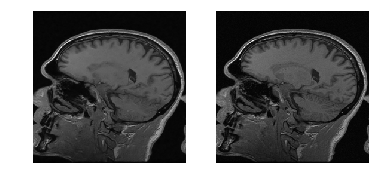

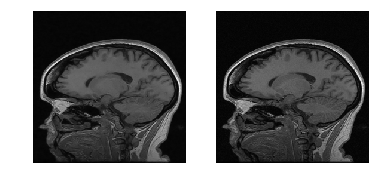

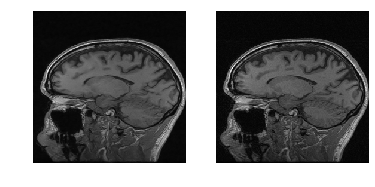

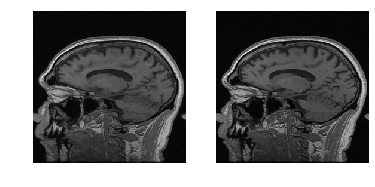

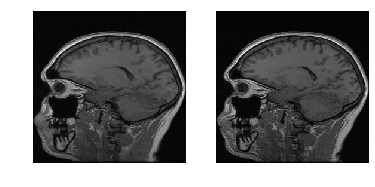

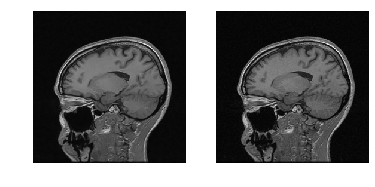

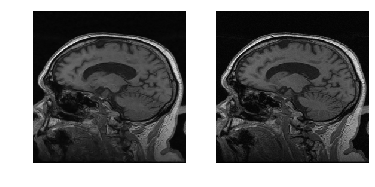

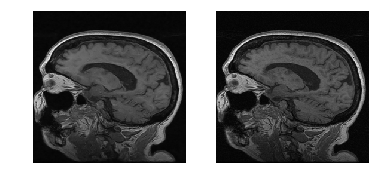

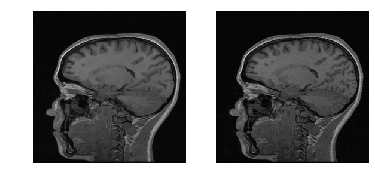

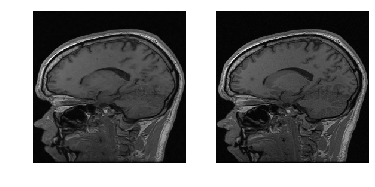

In [5]:
si = 100 # slice to display
for ii in range(len(kspace_files_test)):
    kspace_test = np.load(kspace_files_test[ii])/norm
    rec_test = np.zeros(kspace_test.shape)
    aux = np.fft.ifft2(kspace_test[:,:,:,0]+1j*kspace_test[:,:,:,1])
    rec_test[:,:,:,0] = aux.real
    rec_test[:,:,:,1] = aux.imag
    var_sampling_mask_test = np.tile(var_sampling_mask,(kspace_test.shape[0],1,1,1))
    kspace_test[:,var_sampling_mask] = 0
    pred = model.predict([kspace_test,var_sampling_mask_test])
    #name = kspace_files_test[ii].split("/")[-1].split(".npy")[0]
    #np.save(name + "_rec.npy",pred)
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.abs(pred[si,:,:,0]+1j*pred[si,:,:,1]),cmap = "gray")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(np.abs(rec_test[si,:,:,0]+1j*rec_test[si,:,:,1]),cmap = "gray")
    plt.axis("off")
    plt.show()